In [1]:
import os
import copy
import itertools
import math
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

In [86]:
def load_gap():
    with open('./gp.dat', 'r') as f:
        x,y = [], []
        for l in f.readlines():
            line = l[:-1].rstrip(" ").lstrip("\n").lstrip(" ").split(" ")
            data = [float(i) for i in line if not len(i) == 0]
            x += [data[0]]
            y += [data[1]]
    return np.asarray(x), np.asarray(y)

In [87]:
xdata,ydata = load_gap()

##### Note
matrix by matrix = matrix: K  
matrix by vector = vector: k  
vector by vector = scaler: kappa  

### (C)

In [27]:
def _compute_kernel(x,y,sqrt_gamma=0.12, alpha=1):
    """
    IN: x, y : 1d vec
    OUT: scaler of kernel(i, j)
    """
    coef = -0.5/sqrt_gamma
    return alpha*np.exp( coef*np.sum((x-y)**2) )

#### Bug was in kernel computation!!
coef should be applied to entire `np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)`  
not only first term!! This is why I got ill-PSD matrix!!

In [219]:
def compute_kernel_matrix(x, y,sqrt_gamma=0.12, alpha=1):
    """
    IN: X, Y: n by m matrix(or vector) 
    OUT: covariance matrix
    """
    coef = -0.5/sqrt_gamma
    return alpha*np.exp( coef*(np.sum(x**2, 1).reshape(-1, 1) + np.sum(y**2, 1) - 2 * np.dot(x, y.T)) )

Practice for kernel computation

In [8]:
def test_(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2).reshape(-1, 1) + np.sum(X2**2) - 2 * np.dot(X1, X2.T)
    return sqdist

In [10]:
def test_2(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum((X1-X2)**2)
    return sqdist

In [9]:
x1 = np.ones((2))
x2 = 2*x1
sqdist = test_(x1, x2)

In [11]:
sqdist2 = test_2(x1, x2)

In [12]:
sqdist, sqdist2

(array([[2.]]), 2.0)

In [25]:
np.exp(sqdist2)

7.38905609893065

In [28]:
_compute_kernel(x1,x2, sqrt_gamma=1)

0.36787944117144233

Gen. Prior 

In [220]:
N=1000
z = np.linspace(0,1,N).reshape(-1,1)

In [221]:
mu = np.zeros(z.shape)

In [222]:
cov = compute_kernel_matrix(z,z)

In [223]:
sample =np.random.multivariate_normal(mu.ravel(), cov, 1)[0]

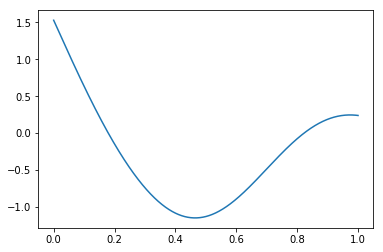

In [224]:
plt.plot(z, sample)

In [225]:
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

In [226]:
samples.shape

(3, 1000)

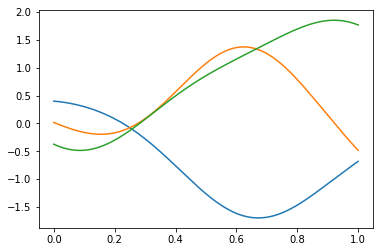

In [227]:
for i in samples:
    plt.plot(z,i)

In [57]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    ''' Isotropic squared exponential kernel. Computes a covariance matrix from points in X1 and X2. Args: X1: Array of m points (m x d). X2: Array of n points (n x d). Returns: Covariance matrix (m x n). '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [58]:
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

In [59]:
samples.shape

(3, 50)

Answer for (c)

In [228]:
samples = np.random.multivariate_normal(mu.ravel(), cov, 20)

Text(0.5,0,'x')

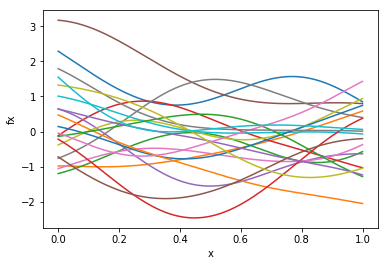

In [229]:
for i in samples:
    plt.plot(z,i)
plt.ylabel('fx')
plt.xlabel("x")

### (d)

In [202]:
def compute_posterior(x_prior, xdata, ydata, sigmma=1.0e-5, sqrt_gamma=0.12, alpha=1):
    # kernels
    K = compute_kernel_matrix(xdata.reshape(-1,1), xdata.reshape(-1,1)) # matrix 
    k_vec = compute_kernel_matrix(xdata.reshape(-1,1), x_prior) # vector
    kappa = compute_kernel_matrix(x_prior,x_prior)+1.0e-10*np.eye(len(x_prior))
    
    # stats
    K_inv = np.linalg.inv(K + sigmma**2*np.eye(K.shape[0]))
    mu_post = k_vec.T.dot(K_inv).dot(ydata)
    cov_post = kappa - k_vec.T.dot(K_inv).dot(k_vec)
    
    return mu_post, cov_post

In [230]:
mu_post, cov_post = compute_posterior(z, xdata, ydata, sigmma=1)

In [231]:
samples_post =  np.random.multivariate_normal(mu_post.ravel(), cov_post, 20)

Text(0.5,0,'x')

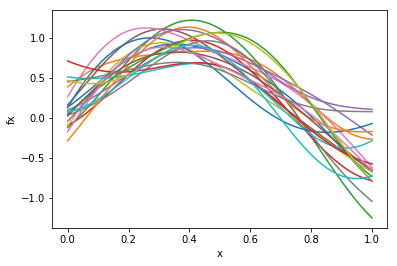

In [232]:
for i in samples_post:
    plt.plot(z,i)
plt.ylabel('fx')
plt.xlabel("x")

In [233]:
upper = mu_post + 2*np.sqrt(np.diag(cov_post))
lower = mu_post - 2*np.sqrt(np.diag(cov_post))

In [234]:
cov_post

array([[ 0.09849969,  0.0981007 ,  0.09770106, ..., -0.00288448,
        -0.00291313, -0.00294165],
       [ 0.0981007 ,  0.09770546,  0.09730959, ..., -0.00285834,
        -0.00288699, -0.00291552],
       [ 0.09770106,  0.09730959,  0.09691746, ..., -0.00283206,
        -0.00286071, -0.00288924],
       ...,
       [-0.00288448, -0.00285834, -0.00283206, ...,  0.09240721,
         0.09282142,  0.09323512],
       [-0.00291313, -0.00288699, -0.00286071, ...,  0.09282142,
         0.09323959,  0.09365727],
       [-0.00294165, -0.00291552, -0.00288924, ...,  0.09323512,
         0.09365727,  0.09407892]])

In [235]:
mu_post.shape

(1000,)

In [211]:
def compute_kernel_inv(x_prior, xdata, ydata, sigmma=1.0, sqrt_gamma=0.12, alpha=1):
    # kernels
    K = compute_kernel_matrix(xdata.reshape(-1,1), xdata.reshape(-1,1)) # matrix 
    k_vec = compute_kernel_matrix(xdata.reshape(-1,1), x_prior) # vector
    kappa = compute_kernel_matrix(x_prior,x_prior)
    
    # stats
    return  np.linalg.inv(K + sigmma**2*np.eye(xdata.shape[0]))

In [236]:
a = compute_kernel_inv(z, xdata, ydata)

-0.09250709635495516 0.9743315137431902


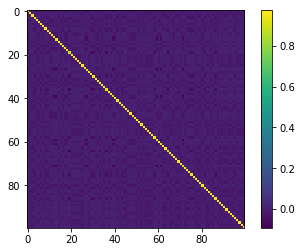

In [237]:
plt.imshow(a)
print(a.min(), a.max() )
plt.colorbar()

In [238]:
upper.max(), upper.min(), lower.max(), lower.min()

(1.2305253029023506,
 0.05119057628282403,
 0.589652038767144,
 -1.1355697874574615)

In [245]:
upper.shape

(1000,)

In [239]:
mu_post.shape

(1000,)

In [240]:
c = np.diag(cov_post)
c.shape

(1000,)

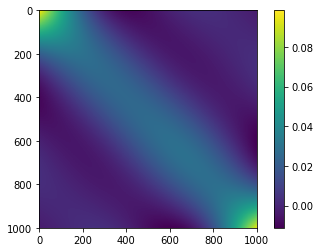

In [241]:
plt.imshow(cov_post)
plt.colorbar()

In [247]:
z.shape

(1000, 1)

Text(0.5,0,'x')

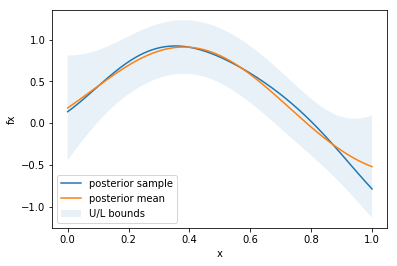

In [252]:
plt.fill_between(z[:,0], upper, lower, alpha=0.1, label='U/L bounds')
plt.plot(z, samples_post[0],label='posterior sample' )
plt.plot(z, mu_post, label='posterior mean')
plt.legend(loc='lower left')
plt.ylabel('fx')
plt.xlabel("x")

Text(0.5,0,'x')

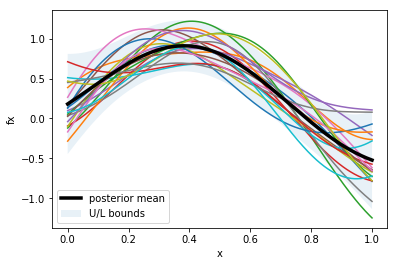

In [259]:
plt.fill_between(z[:,0], upper, lower, alpha=0.1, label='U/L bounds')
for ii in range(len(samples)) :
    plt.plot(z, samples_post[ii] )
plt.plot(z, mu_post, label='posterior mean', c='black', linewidth=3.5)
plt.legend(loc='lower left')
plt.ylabel('fx')
plt.xlabel("x")

practice

In [165]:
def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    ''' Computes the suffifient statistics of the GP posterior predictive distribution from m training data X_train and Y_train and n new inputs X_s. Args: X_s: New input locations (n x d). X_train: Training locations (m x d). Y_train: Training targets (m x 1). l: Kernel length parameter. sigma_f: Kernel vertical variation parameter. sigma_y: Noise parameter. Returns: Posterior mean vector (n x d) and covariance matrix (n x n). '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [168]:
# Noise free training data
X = np.arange(-5, 5, 0.2).reshape(-1, 1)
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

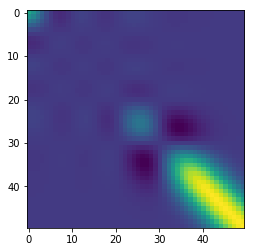

In [169]:
plt.imshow(cov_s)

In [170]:
X.shape, X_train.shape

((50, 1), (5, 1))